In [1]:
import os
import pandas as pd 
import numpy as np
#import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline
import os, shutil, glob
import re, math
import seaborn as sns; sns.set_style("white")
import datetime
import gc
from pathlib import Path

from cytominer_eval import evaluate
#import plotly.graph_objects as go
#import plotly.offline as pyo
#import plotly.io as pio
#pio.renderers

os.getcwd()

'/Users/chririn/Documents/Code/2D_analysis_v2'

In [2]:
figformat = "png"
dpi = 150

In [3]:
#OutputDir = input("Enter name for output folder: ")  #
OutputDir = "./results/"
if not os.path.exists(OutputDir):
    os.makedirs(OutputDir)


## Grit

In [8]:
selected_df = pd.read_csv("{}/colopaint44_selected_data.csv".format(OutputDir), sep=";", index_col=0)
# selected_df = dfZscores.drop(dfZscores.columns[[0]], axis=1)  # df.columns is zero-based pd.Index
selected_df.head(3)

,Metadata_layout_id,Metadata_well_id,Metadata_batch_id,Metadata_solvent,Metadata_stock_conc,Metadata_stock_conc_unit,Metadata_cmpd_vol,Metadata_cmpd_vol_unit,Metadata_well_vol,Metadata_well_vol_unit,...,RadialDistribution_ZernikePhase_illumPHAandWGA_4_4_cytoplasm,Granularity_9_illumMITO_nuclei_MAD,Correlation_Manders_illumHOECHST_illumCONC_nuclei,RadialDistribution_ZernikePhase_illumCONC_9_5_cells_MAD,RadialDistribution_ZernikePhase_illumPHAandWGA_6_6_nuclei,Correlation_RWC_illumHOECHST_illumPHAandWGA_nuclei,RadialDistribution_ZernikePhase_illumMITO_3_1_cells_MAD,Correlation_K_illumSYTO_illumHOECHST_cells_MAD,RadialDistribution_MeanFrac_illumSYTO_2of4_nuclei,AreaShape_Zernike_7_1_cytoplasm_MAD
0,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B02,PHB000015,dmso,10.0,mM,7.5,nL,30,uL,...,0.775039,-0.701098,0.0,-0.032029,-1.392480,2.578443,-1.493628,-0.679904,2.999423,0.481920
1,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B04,BJ1827053,dmso,0.1,mM,2.5,nL,30,uL,...,-1.538909,-2.060545,0.0,1.072894,-1.206460,-0.981357,0.930732,-0.928100,1.421850,-0.019227
2,colo44-v1-FA-P017365-CACO2-48h-P1-L1,B05,PHB000001,dmso,100.0,perc,30.0,nL,30,uL,...,-0.184617,-0.707096,0.0,-0.733259,0.135866,-1.571043,-0.810567,-0.998484,0.984039,0.554717


In [16]:
# Remove non-data features from the list
ListOfSelectedFeatures = list(selected_df.columns.values)
ListOfMetadata = list(selected_df.columns[selected_df.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))
ListOfMetadata.append('CompRepl')

In [19]:
dataset = selected_df.copy()
dataset["CompRepl"] = (
    dataset["Metadata_cmpd"] + "_" + dataset.index.astype(str)
    )  


In [22]:
control_perts = dataset.query("Metadata_cmpd == '[dmso]'").CompRepl.unique().tolist()

In [23]:
grit_replicate_groups = {"profile_col": "CompRepl", "replicate_group_col": "Metadata_cmpd_conc"}

In [32]:
grit_scores = []

# for cell_line in datasetPart.plate.unique():
#    cell_line_df = datasetPart.query("plate == @cell_line")

grit_results = evaluate(
    profiles=dataset,
    features=ListOfSelectedFeatures,
    meta_features=ListOfMetadata,
    replicate_groups=grit_replicate_groups,
    operation="grit",
    similarity_metric="pearson",
    grit_replicate_summary_method="median",
    grit_control_perts=control_perts,
)  # .assign(cell_line=cell_line)

grit_scores.append(grit_results)

In [25]:
grit_scores = pd.concat(grit_scores).reset_index(drop=True)
print(grit_scores.shape)
grit_scores.head()

(1227, 3)


,perturbation,group,grit
0,5-Fluo_136,0.333,0.247781
1,5-Fluo_147,0.1,-0.129125
2,5-Fluo_165,1.0,1.053145
3,5-Fluo_214,0.0333,0.176489
4,5-Fluo_220,1.0,0.712834


In [26]:
grit_scores["perturbation"]

0       5-Fluo_136
1       5-Fluo_147
2       5-Fluo_165
3       5-Fluo_214
4       5-Fluo_220
           ...    
1222    vemura_507
1223    vemura_528
1224    vemura_580
1225    vemura_605
1226     vemura_91
Name: perturbation, Length: 1227, dtype: object

In [27]:
grit_scores["Metadata_cmpd"] = grit_scores["perturbation"].str.split("_").str[0]
grit_scores["Metadata_cmpd_conc"] = grit_scores["group"]
grit_scores.tail(9)

,perturbation,group,grit,Metadata_cmpd,Metadata_cmpd_conc
1218,vemura_416,0.00833,0.060103,vemura,0.00833
1219,vemura_42,0.00833,0.036174,vemura,0.00833
1220,vemura_462,0.1,0.398353,vemura,0.1
1221,vemura_483,10.0,-1.131781,vemura,10.0
1222,vemura_507,0.00833,-0.013662,vemura,0.00833
1223,vemura_528,1.0,-0.880552,vemura,1.0
1224,vemura_580,10.0,-0.230888,vemura,10.0
1225,vemura_605,0.333,-0.358241,vemura,0.333
1226,vemura_91,10.0,-0.805909,vemura,10.0


In [28]:
grit_scores.to_csv("{}/grit_scores.csv".format(OutputDir), sep=";")

In [30]:
CompoundsUsed = sorted(list(set(grit_scores["Metadata_cmpd"])))
print(CompoundsUsed)
print(len(CompoundsUsed))

['5-Fluo', '5Z-7-O', 'ABT-73', 'AMG 23', 'AZD454', 'AZD776', 'AZD805', 'Abemac', 'Afatin', 'BMS-75', 'Crizot', 'Dabraf', 'Encora', 'Gefiti', 'LGK974', 'LY2603', 'Linsit', 'MK-177', 'MK-220', 'Navito', 'Nutlin', 'Olapar', 'Oxalip', 'PD0325', 'PI-103', 'Paclit', 'Palboc', 'Ruxoli', 'SB2167', 'SB5051', 'SN-38', 'Sapiti', 'Taseli', 'Temozo', 'Tramet', 'Velipa', 'Vinore', '[berb]', '[dmso]', '[etop]', '[fenb]', '[flup]', '[tetr]', 'alpeli', 'binime', 'cobime', 'regora', 'tricir', 'triflu', 'vemura']
50


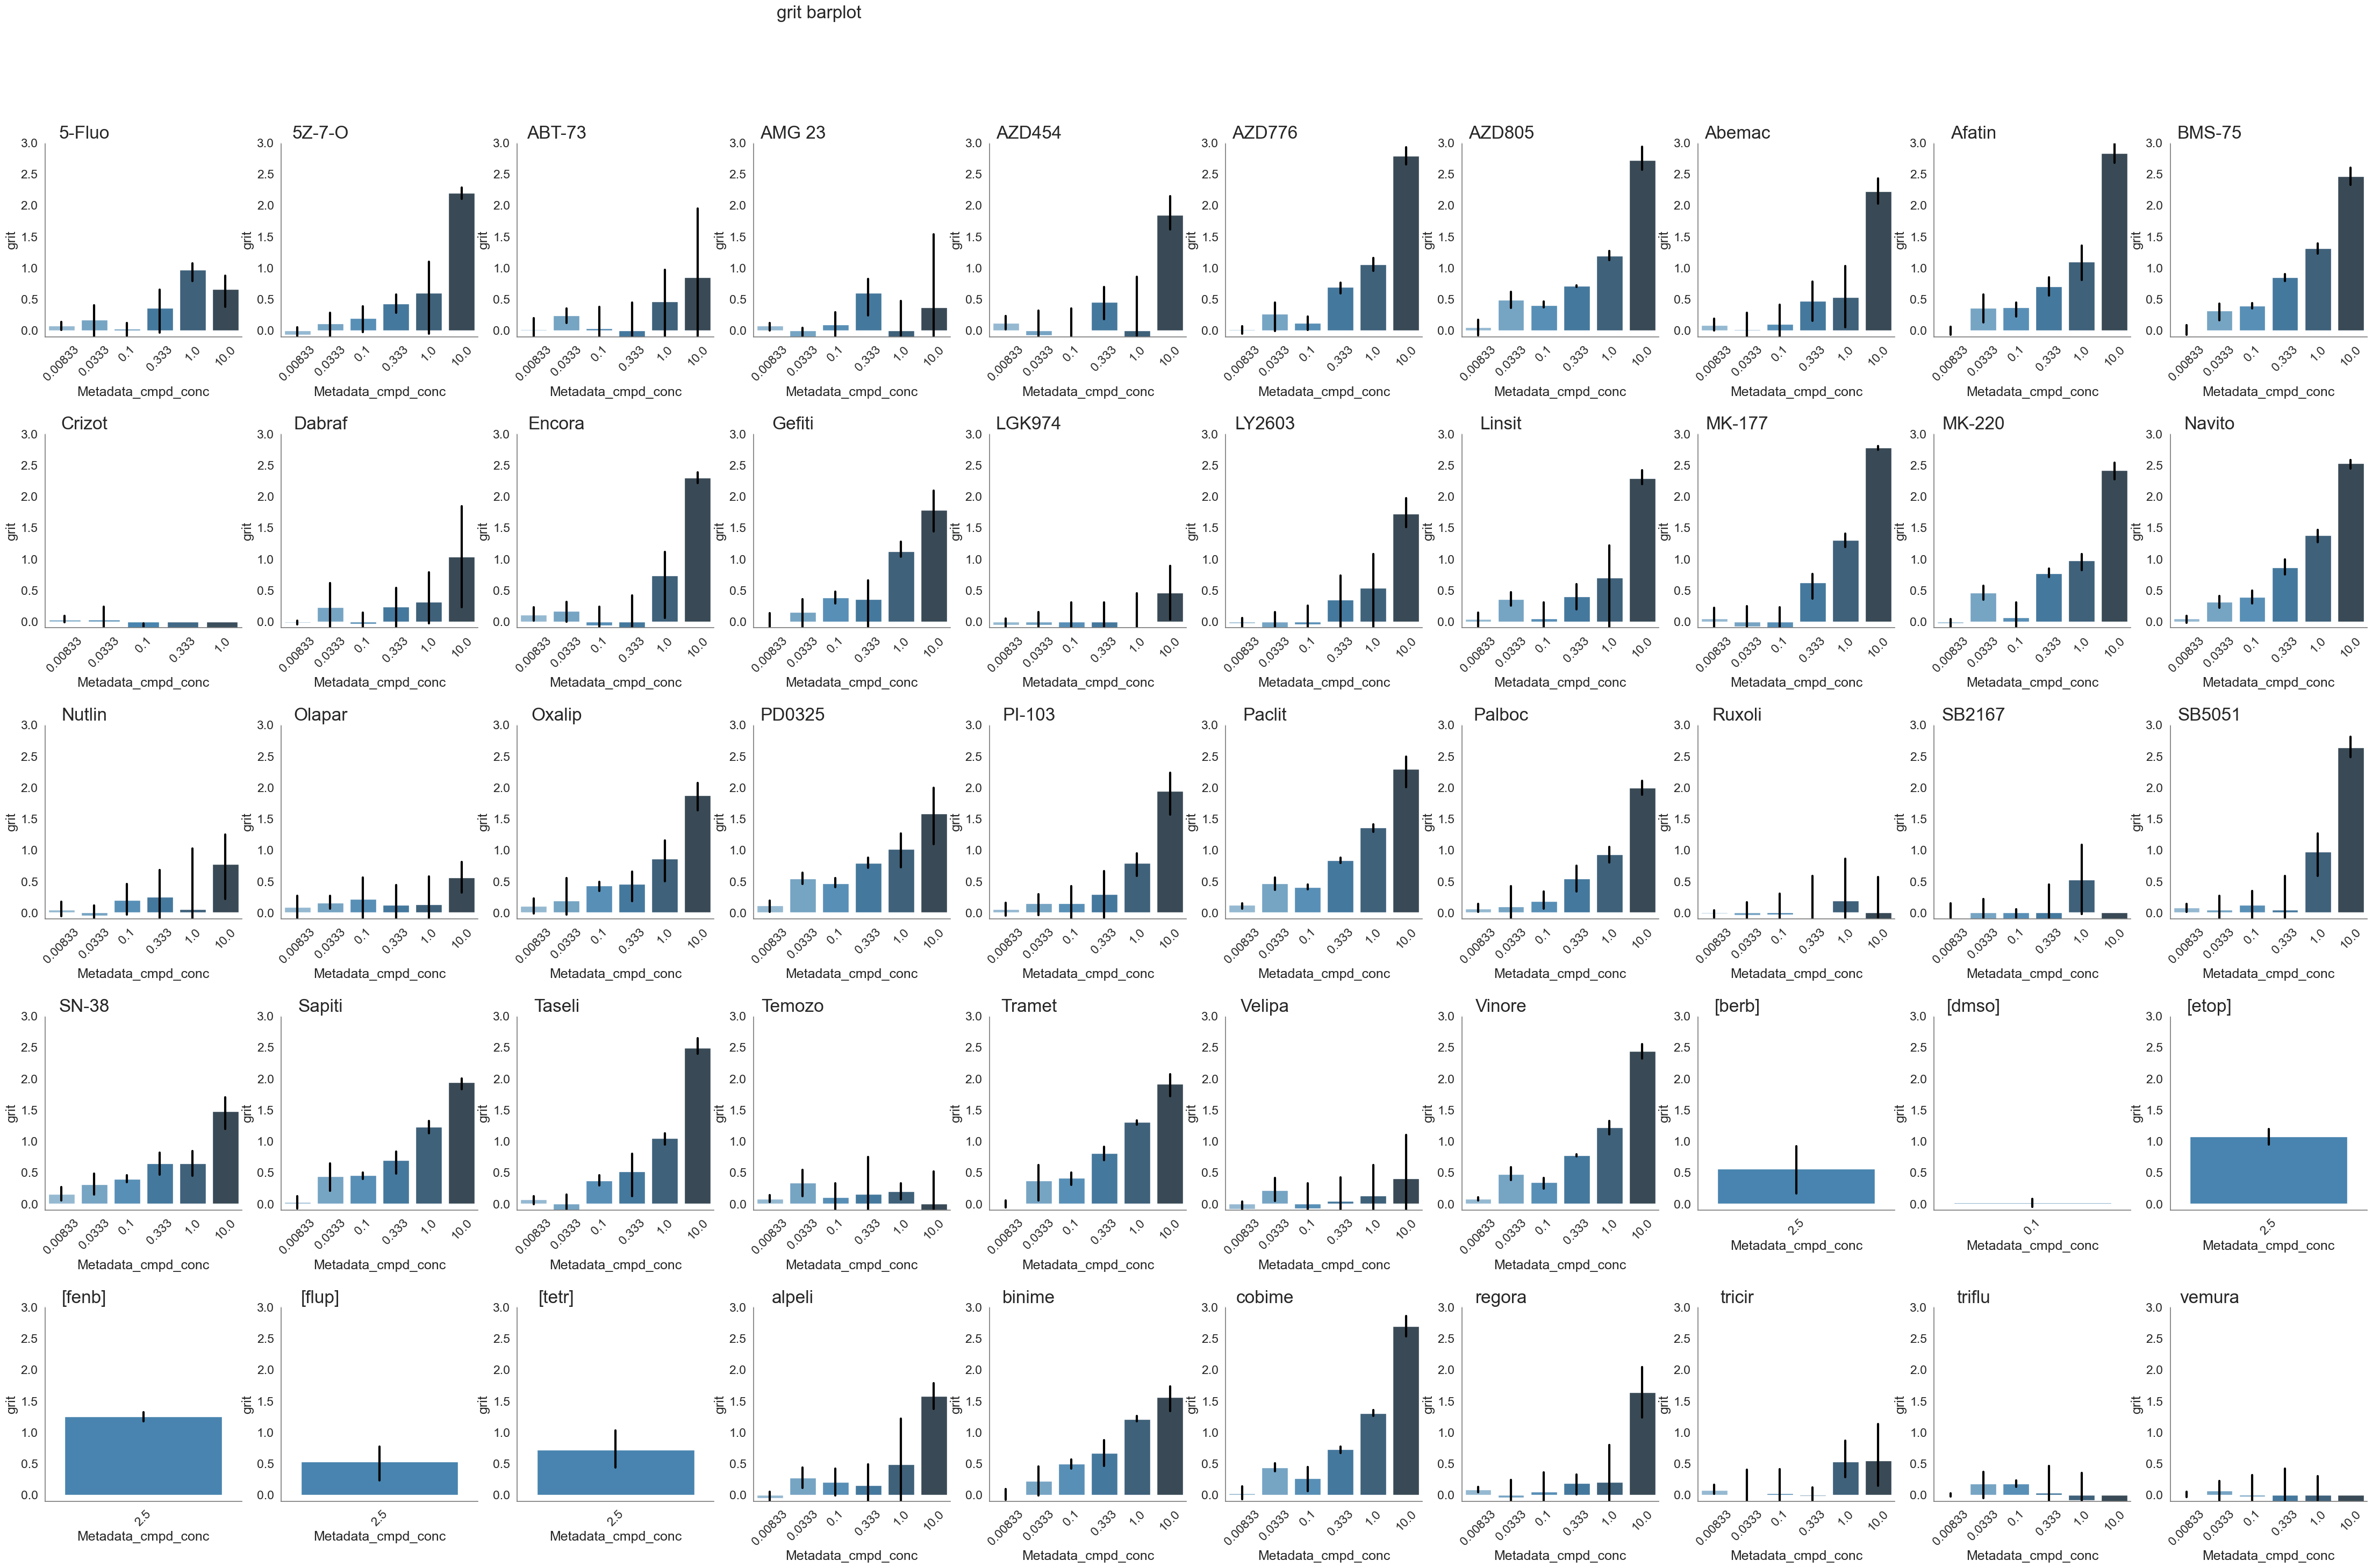

In [31]:
fig = plt.figure(figsize=(48, 32))
sns.set(font_scale=1.5)
fig.suptitle("grit barplot", fontsize=24, x=0.3)
sp = 1
nrrow = 5
nrcol = 10
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores["Metadata_cmpd"] == some].copy()
    grit_scores_part.sort_values(by="Metadata_cmpd_conc", inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax = sns.barplot(
        x="Metadata_cmpd_conc",
        y="grit",
        data=grit_scores_part,
        palette="Blues_d",
        alpha=1,
        errcolor="black",
        errwidth=3,
    )
    ax.set_facecolor("w")
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.set_ylim([-0.1, 3])
    ax.set_title("{}".format(some), fontsize=24, x=0.2)
    plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5, left=0.0)
    plt.xticks(rotation = 45)
    sp += 1
#fig.savefig(
#    "{}/grit_barplots.{}".format(OutputDir, "png"), dpi=150, bbox_inches="tight"
#)
#fig.savefig(
#    "{}/grit_barplots.{}".format(OutputDir, "pdf"), dpi=300, bbox_inches="tight"
#)
plt.show()
